In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score

In [ ]:
#runtime
total_start_time = time.time()

np.random.seed(42)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [ ]:
#Load Data
print("Loading Fashion-MNIST")
(x_train_full, y_train_full), (x_test_raw, y_test_raw) = fashion_mnist.load_data()

class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

#Flatten images and normalize at [0.1]
x_train_full = x_train_full.reshape(-1, 784).astype('float32') / 255.0
x_test = x_test_raw.reshape(-1, 784).astype('float32') / 255.0

Loading Fashion-MNIST


In [ ]:
#Train/Val/Test
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full,
    y_train_full,
    test_size=0.1,
    random_state=42
)
print(f"Data Split -> Train: {x_train.shape}, Validation: {x_val.shape}, Test: {x_test.shape}")

Data Split -> Train: (54000, 784), Validation: (6000, 784), Test: (10000, 784)



Visualizing random RAW images


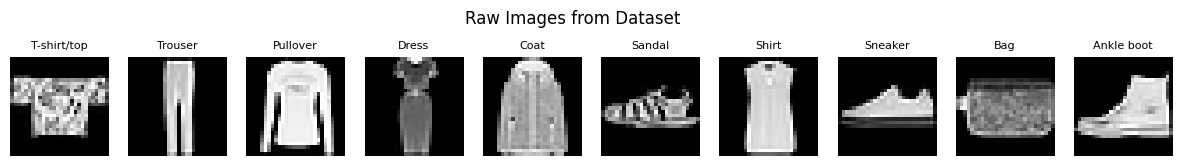

In [ ]:
#RAW
print("\nVisualizing random RAW images")
unique_classes = np.unique(y_train)
plt.figure(figsize=(15, 2))
for i, cls in enumerate(unique_classes):
    idx = np.where(y_train == cls)[0][0]
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(x_train[idx].reshape(28, 28), cmap='gray')
    plt.title(class_names[cls], fontsize=8)
    plt.axis('off')
plt.suptitle("Raw Images from Dataset")
plt.show()

#Results
columns = [
    'DR_Technique', 'Clustering_Algo',
    'DR_Training_Time_s', 'Clustering_Exec_Time_s',
    'Suggested_Clusters', 'Calinski_Harabasz',
    'Davies_Bouldin', 'Silhouette', 'ARI_Score'
]
results_df = pd.DataFrame(columns=columns)

In [ ]:
#Function for consistent comparisons
def run_clustering_suite(X_data, y_true, dr_name, dr_time):
    global results_df

    clustering_algos = [
        ('MiniBatchKMeans', MiniBatchKMeans(n_clusters=10, batch_size=2048, n_init='auto', random_state=42)),
        ('DBSCAN', DBSCAN(eps=0.5, min_samples=5)),
        ('Agglomerative', AgglomerativeClustering(n_clusters=10))
    ]

    print(f"Running clustering algorithms on {dr_name} features")

    for algo_name, model in clustering_algos:
        if algo_name == 'DBSCAN':
            if dr_name == 'Raw': model.set_params(eps=100.0)
            elif dr_name == 'PCA': model.set_params(eps=3.5)
            elif dr_name == 'SAE': model.set_params(eps=0.5)
            elif dr_name == 't-SNE': model.set_params(eps=2.5)

        start_clust = time.time()
        labels = model.fit_predict(X_data)
        clust_time = time.time() - start_clust

        unique_labels = np.unique(labels)
        n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)

        #Ignoring noise
        ch, db, sil, ari = 0.0, 0.0, 0.0, 0.0
        ari = adjusted_rand_score(y_true, labels)

        if n_clusters > 1:
            mask = labels != -1
            if np.sum(mask) > 1:
                X_clean = X_data[mask]
                labels_clean = labels[mask]

                #Samples for time consumption
                sample_size = 5000 if len(X_clean) > 5000 else None

                ch = calinski_harabasz_score(X_clean, labels_clean)
                db = davies_bouldin_score(X_clean, labels_clean)
                sil = silhouette_score(X_clean, labels_clean, sample_size=sample_size)

        new_row = {
            'DR_Technique': dr_name,
            'Clustering_Algo': algo_name,
            'DR_Training_Time_s': round(dr_time, 4),
            'Clustering_Exec_Time_s': round(clust_time, 4),
            'Suggested_Clusters': n_clusters,
            'Calinski_Harabasz': round(ch, 2),
            'Davies_Bouldin': round(db, 4),
            'Silhouette': round(sil, 4),
            'ARI_Score': round(ari, 4)
        }
        results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)


Processing RAW DATA
Running clustering algorithms on Raw features


/tmp/ipython-input-2951037922.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)



Processing PCA


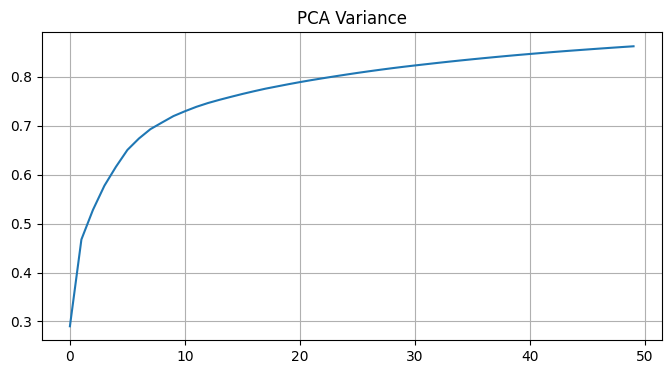

Running clustering algorithms on PCA features


In [ ]:
#RAW DATA
print("\nProcessing RAW DATA")
run_clustering_suite(x_test, y_test_raw, "Raw", 0.0)

#PCA ONLY on training data
print("\nProcessing PCA")
start_dr = time.time()
pca = PCA(n_components=50, random_state=42)
pca.fit(x_train)
dr_time_pca = time.time() - start_dr

#Plot
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('PCA Variance')
plt.grid(True); plt.show()

x_test_pca = pca.transform(x_test)
run_clustering_suite(x_test_pca, y_test_raw, "PCA", dr_time_pca)


Processing Stacked Autoencoder
Epoch 1/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.0710 - val_loss: 0.0235
Epoch 2/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0221 - val_loss: 0.0189
Epoch 3/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0182 - val_loss: 0.0165
Epoch 4/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0163 - val_loss: 0.0151
Epoch 5/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - loss: 0.0148 - val_loss: 0.0140
Epoch 6/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.0139 - val_loss: 0.0137
Epoch 7/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0131 - val_loss: 0.0126
Epoch 8/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0125 - val_loss: 0.0125
Epoch 9/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0122 - val_loss: 0.0117
Epoch 10/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0115 - val_loss: 0.0115
Epoch 11/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0112 - val_loss: 0.0112
Epoch 12

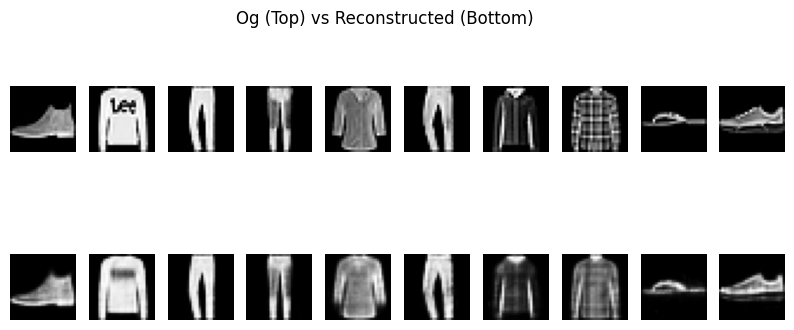

Running clustering algorithms on SAE features


In [ ]:
#Stacked Autoencoder
print("\nProcessing Stacked Autoencoder")
input_img = Input(shape=(784,))

#No more than 128(just copies input to output)
encoded = Dense(256, activation='relu')(input_img)
encoded = Dense(128, activation='relu')(encoded)
encoded_out = Dense(128, activation='relu')(encoded)

#Decoder
decoded = Dense(128, activation='relu')(encoded_out)
decoded = Dense(256, activation='relu')(decoded)
decoded_out = Dense(784, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded_out)
encoder = Model(input_img, encoded_out)
autoencoder.compile(optimizer='adam', loss='mse')

#Early stopping to save time and avoid overtraining (epochs max=53 out of 100, min=47 out of 50)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

start_dr = time.time()
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_val, x_val),
                callbacks=[early_stopping],
                verbose=1)
dr_time_sae = time.time() - start_dr

# Reconstruction Plot
print("Visualizing Reconstruction")
test_imgs = x_test[:10]
reconst_imgs = autoencoder.predict(test_imgs, verbose=0)
plt.figure(figsize=(10, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1); plt.imshow(test_imgs[i].reshape(28,28), cmap='gray'); plt.axis('off')
    ax = plt.subplot(2, 10, i + 11); plt.imshow(reconst_imgs[i].reshape(28,28), cmap='gray'); plt.axis('off')
plt.suptitle("Og (Top) vs Reconstructed (Bottom)"); plt.show()

x_test_sae = encoder.predict(x_test, verbose=0)
run_clustering_suite(x_test_sae, y_test_raw, "SAE", dr_time_sae)


Processing t-SNE
Applying t-SNE on full test set


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


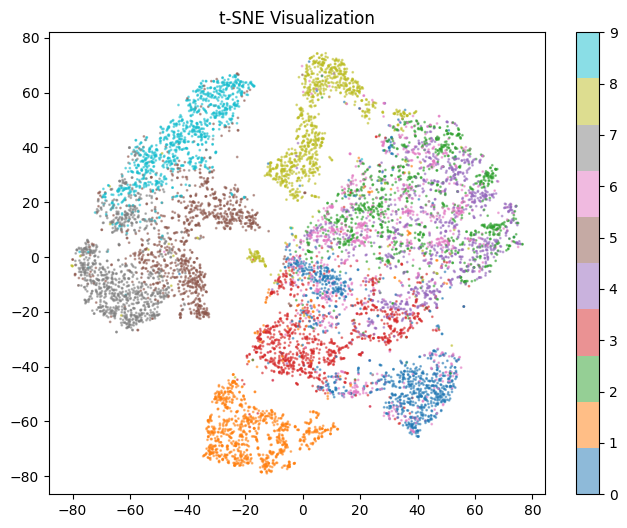

Running clustering algorithms on t-SNE features


In [ ]:
#t-SNE
print("\nProcessing t-SNE")
print("Applying t-SNE on full test set")
start_dr = time.time()
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
x_test_tsne = tsne.fit_transform(x_test)
dr_time_tsne = time.time() - start_dr

#t-SNE Visualization
plt.figure(figsize=(8, 6))
plt.scatter(x_test_tsne[:, 0], x_test_tsne[:, 1], c=y_test_raw, cmap='tab10', s=1, alpha=0.5)
plt.colorbar(); plt.title('t-SNE Visualization'); plt.show()

run_clustering_suite(x_test_tsne, y_test_raw, "t-SNE", dr_time_tsne)


FINAL RESULTS DATAFRAME


,DR_Technique,Clustering_Algo,DR_Training_Time_s,Clustering_Exec_Time_s,Suggested_Clusters,Calinski_Harabasz,Davies_Bouldin,Silhouette,ARI_Score
0,Raw,MiniBatchKMeans,0.0000,0.9320,10,1227.020020,2.0804,0.1337,0.3965
1,Raw,DBSCAN,0.0000,24.2507,1,0.000000,0.0000,0.0000,0.0000
2,Raw,Agglomerative,0.0000,38.9735,10,1116.130005,1.9335,0.1188,0.3478
3,PCA,MiniBatchKMeans,0.8455,0.0539,10,1749.479980,1.7048,0.1796,0.3424
4,PCA,DBSCAN,0.8455,0.5777,6,13.920000,1.2276,-0.1427,0.0023
5,PCA,Agglomerative,0.8455,8.6769,10,1554.239990,1.6664,0.1530,0.3358
6,SAE,MiniBatchKMeans,286.6804,0.1114,10,1298.020020,2.0320,0.1328,0.2589
7,SAE,DBSCAN,286.6804,0.9837,0,0.000000,0.0000,0.0000,0.0000
8,SAE,Agglomerative,286.6804,11.5593,10,1182.609985,2.0399,0.1168,0.3577
9,t-SNE,MiniBatchKMeans,142.4659,0.0344,10,11753.150391,0.7985,0.4223,0.4195



Visualizing Clusters


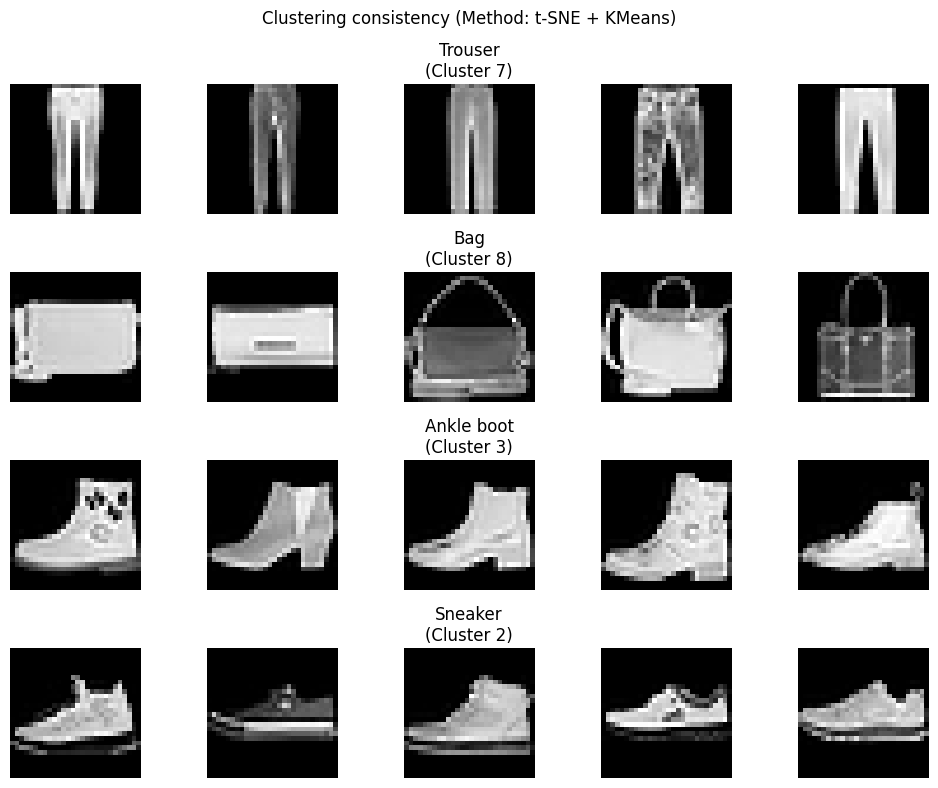

In [ ]:
# Final Results Data
print("\nFINAL RESULTS DATAFRAME")
display(results_df)

#Cluster Visualization
print("\nVisualizing Clusters")

mbk_final = MiniBatchKMeans(n_clusters=10, random_state=42, n_init='auto')
labels_final = mbk_final.fit_predict(x_test_tsne)

target_classes = [1, 8, 9, 7] #Trouser, Bag, Boot, Sneaker
plt.figure(figsize=(10, 8))

#For truly random final results
np.random.seed(None)

#Most dominant cluster for each class selected
for i, cls_id in enumerate(target_classes):
    indices = np.where(y_test_raw == cls_id)[0]
    dom_cluster = np.bincount(labels_final[indices]).argmax()
    cluster_idxs = np.where(labels_final == dom_cluster)[0]

    np.random.shuffle(cluster_idxs)

    for j in range(5):
        if j < len(cluster_idxs):
            ax = plt.subplot(4, 5, i*5 + j + 1)
            plt.imshow(x_test[cluster_idxs[j]].reshape(28,28), cmap='gray')
            if j == 2: plt.title(f"{class_names[cls_id]}\n(Cluster {dom_cluster})")
            plt.axis('off')

plt.suptitle("Clustering consistency (Method: t-SNE + KMeans)")
plt.tight_layout(); plt.show()

In [ ]:
#Execution time
total_end_time = time.time()
total_seconds = total_end_time - total_start_time
minutes = int(total_seconds // 60)
seconds = int(total_seconds % 60)

print(f"\nTOTAL EXECUTION TIME: {minutes} minutes and {seconds} seconds")



TOTAL EXECUTION TIME: 8 minutes and 54 seconds
